In [30]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from Algorithms.HelicopterTriggerIndex import *

In [6]:
def HTI_climatology(folder,yellow_treshold,brown_treshold,red_treshold,varname="helicopter_triggered_index"):
    treshold_yellow = yellow_treshold; yellow = 0
    treshold_brown  = brown_treshold ; brown  = 0
    treshold_red    = red_treshold   ; red    = 0
    temp = []
    
    print(len(os.listdir(folder)))
    k = 0

    for file in sorted(os.listdir(folder)):
        if file.endswith(".nc"):
            k +=1
            HTI_forecasted_count = xr.open_dataset(folder+file)[varname]
            try:
                yellow += np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
                brown  += np.sum(HTI_forecasted_count > treshold_brown,axis=0)
                red    += np.sum(HTI_forecasted_count > treshold_red,axis=0)
            except xr.MergeError:
                temp.append([yellow,brown,red])
                yellow = np.sum(HTI_forecasted_count > treshold_yellow,axis=0)
                brown  = np.sum(HTI_forecasted_count > treshold_brown,axis=0)
                red    = np.sum(HTI_forecasted_count > treshold_red,axis=0)
        if k%250 == 0:
            print(k)

    yellow = temp[0][0].reset_coords("time",drop=1) + yellow.sel(x=temp[0][0].x,method="nearest").values
    brown  = temp[0][1].reset_coords("time",drop=1) + brown.sel(x=temp[0][1].x,method="nearest").values
    red    = temp[0][2].reset_coords("time",drop=1) + red.sel(x=temp[0][2].x,method="nearest").values
    
    for elem in temp[1:]:
        yellow += elem[0].reset_coords("time",drop=1) + yellow.sel(x=temp[0][0].x,method="nearest").values
        brown  += elem[1].reset_coords("time",drop=1) + brown.sel(x=temp[0][1].x,method="nearest").values
        red    += elem[2].reset_coords("time",drop=1) + red.sel(x=temp[0][2].x,method="nearest").values
        
    return yellow,brown,red

folder = "source_disk/MEPS/HTI_forecast/"


In [54]:
def forecast_from_extracted(infile,outfile):
    ds = xr.open_dataset(infile)
    
    new_ds = xr.Dataset(  {
        "air_temp": (("ensemble_member","y", "x"), air_temp),
        "W_": (("ensemble_member","y", "x"), W_),
        "geo_sf": (("ensemble_member","y", "x"), geo_sf.values[0]),
        "prec": (("ensemble_member","y", "x"),prec.values[0]),
        "lowcloud": (("ensemble_member","y", "x"), lowcloud.values[0]),
     },
     coords={"time":ds.time,'ensemble_member':ds.ensemble_member, 'x': ds.x,'y': ds.y},
    )     
    for t in range(ds.dims["time"]):
        geo_pl, geo_sf, airtemp_pl, upward_pl, lowcloud, prec = fetchfields(ds,t)
        air_temp = get_height_value_from_pl(geo_pl,airtemp_pl-273.15)
        W_ = get_height_value_from_pl(geo_pl,upward_pl)
        
        Nbh = 7
        
        W = np.zeros_like(W_)
        topomin = np.zeros_like(W)
        topomax = np.zeros_like(topomin)
        cl = np.zeros_like(lowcloud)
        pc = np.zeros_like(prec)

        for member in W_["ensemble_member"]:
            W[member] = neighbourhood_max(W_.isel(ensemble_member=member).values,Nbh)
            cl[member] = neighbourhood_max(lowcloud.isel(ensemble_member=member).values,Nbh)
            cl[member] -= neighbourhood_min(lowcloud.isel(ensemble_member=member).values,Nbh)
            pc[member] = neighbourhood_max(prec.isel(ensemble_member=member).values,Nbh)
            topomax[member] = neighbourhood_max(geo_sf.isel(ensemble_member=member).values,Nbh)
            topomin[member] = neighbourhood_min(geo_sf.isel(ensemble_member=member).values,Nbh)

        HTI = HelicopterTriggerIndex([tfunc,wfunc,pfunc,cfunc])
        result = HTI([air_temp.values,W,pc,cl])

        result[np.where(topomax >= 7500)] = 0
        result[np.where(topomin >= 10)] = 0
        def mask(array,topmax=topomax,topmin=topomin):
            array[np.where(topmax >= 7500)] = 0
            array[np.where(topmin >= 10)] = 0
            return array    

        T = mask(tfunc(air_temp.values))
        Wn = mask(wfunc(W))
        P = mask(pfunc(pc))
        C = mask(cfunc(cl))
        new_ds=new_ds.assign(HTI=((("ensemble_member","y", "x")),result))
        new_ds=new_ds.assign(T=((("ensemble_member","y", "x")),T))
        new_ds=new_ds.assign(W=((("ensemble_member","y", "x")),Wn))
        new_ds=new_ds.assign(P=((("ensemble_member","y", "x")),P))
        new_ds=new_ds.assign(C=((("ensemble_member","y", "x")),C))
    
    
    
    
    
    new_ds.to_netcdf(outfile)
    return 0
    
def forecast_from_subset(infile,outfile,HTI_class):
    
    
    
    
    ds.to_netcdf(outfile)
    return 0

In [52]:
ds = xr.open_dataset("source_disk/results/HTI_climatology_MEPS")
yellow = ds["yellow"]
ds.attrs["about"] = "Percentage of forecasted above tresholds (see threholds attribute)"


In [59]:
ds.dims["x"]


719

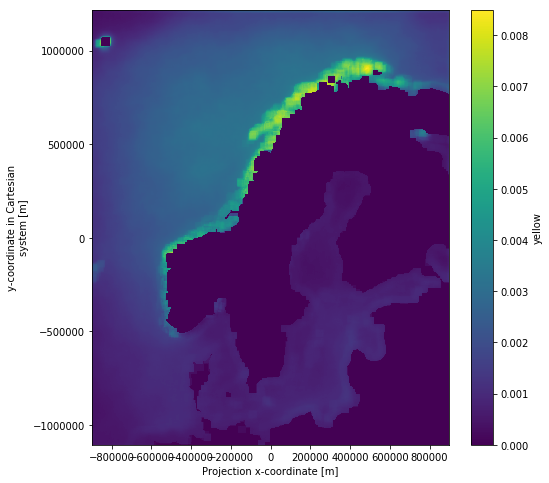

In [45]:
plt.figure(figsize=(8,8))
(yellow/(k*20)).plot()

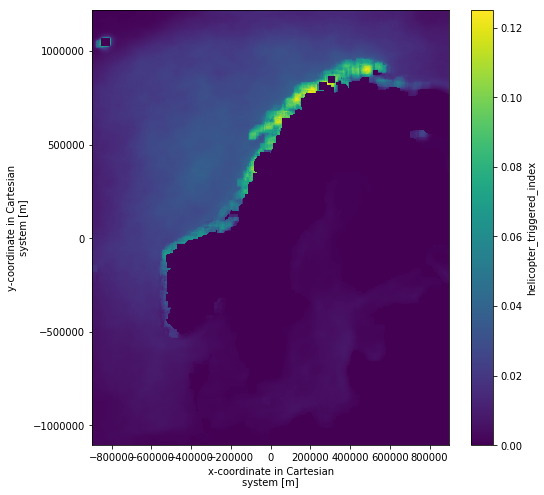

In [6]:
plt.figure(figsize=(8,8))

(brown/(k*20)).plot()

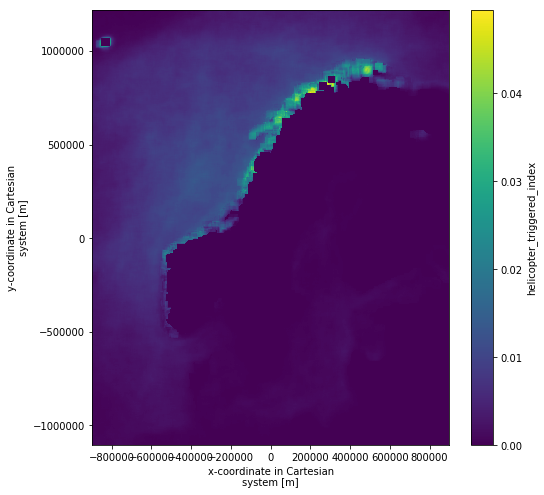

In [7]:
plt.figure(figsize=(8,8))

(red/(k*20)).plot()

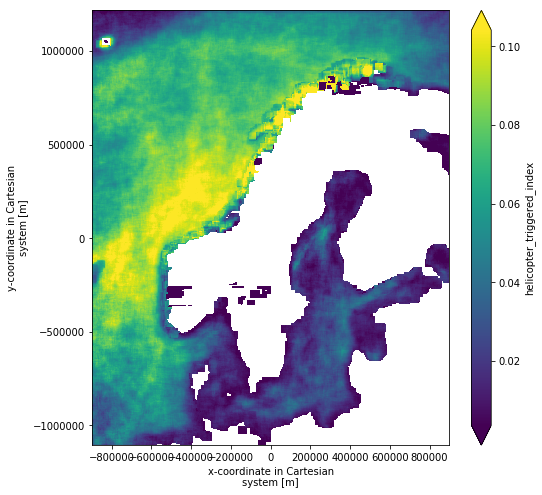

In [8]:
plt.figure(figsize=(8,8))

(red/yellow).plot(robust=1)

In [17]:
ds = xr.merge([yellow.rename("yellow"),brown.rename("brown"),red.rename("red")])/(k*20)

In [19]:
ds.to_netcdf("source_disk/results/HTI_climatology_MEPS")